# A/B - тест маркетплейса

Анализ a/b-теста для оценки влияния введения платных возвратов на количество сделанных заказов на маркетплейсе

## 1. для начала проанализируем датасет без разделения на сегменты

Датасет состоит из следующих колонок:

id – id клиента

group - 
       
       A – стоимость возврата одной вещи = 0 рублей, 

       B – стоимость возврата одной вещи = 50 рублей, 
       
       C – стоимость возврата одной вещи = 75 рублей
       
orders – число заказов за месяц


В качестве метрики выберем число заказов

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import warnings
import scipy as sp
%matplotlib inline

In [4]:
warnings.filterwarnings('ignore')

In [5]:
ab_test_return = pd.read_csv('ab_test_return_csv.csv')

Взглянем на датасет

In [6]:
ab_test_return

,id,group,orders
0,689,A,137
1,3800,A,164
2,1520,A,149
3,11580,A,181
4,10474,A,132
...,...,...,...
11995,1973,C,95
11996,8620,C,72
11997,319,C,74
11998,8610,C,98


In [7]:
ab_test_return.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      12000 non-null  int64 
 1   group   12000 non-null  object
 2   orders  12000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 281.4+ KB


В датасете 12000 строк и 3 колонки, пропущенных значений нет

Проверим дубликаты id клиентов

In [8]:
ab_test_return.duplicated(subset=['id']).sum()

0

Для того, что бы проверить гипотезу об отсутствии статистически значимых различий между группами, нам надо проверить предположения о нормальности распределения и однородности дисперсий. Воспользуемся тестом Шапиро-Уилка и тестом Левена соответственно 

<AxesSubplot:xlabel='group', ylabel='orders'>

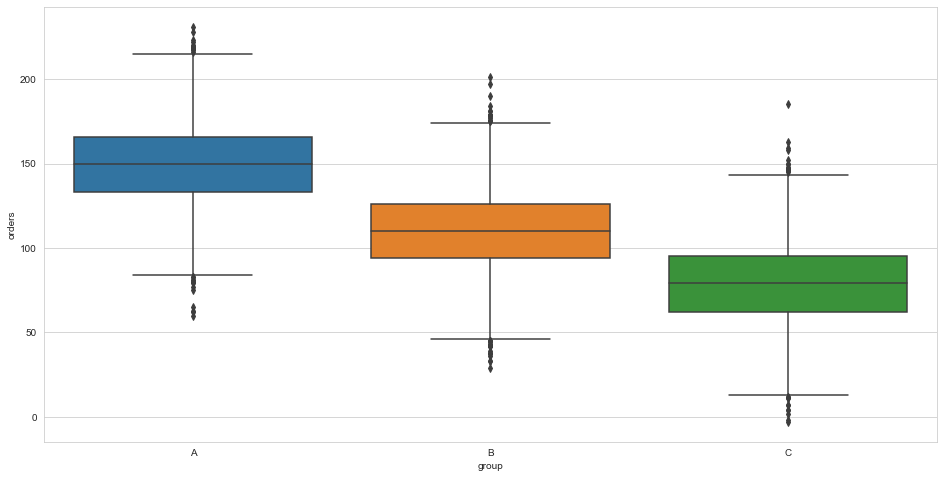

In [155]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='group',y='orders', data=ab_test_return)

На графике боксплота между группами заметны различия в средних, распределение нормальное, без явных выбросов и эксцессов

In [9]:
# Тест Левена
# Уровень значимости = 0.05
alpha = 0.05
result = st.levene(ab_test_return[ab_test_return['group'] == 'A'].orders,
                   ab_test_return[ab_test_return['group'] == 'B'].orders,
                   ab_test_return[ab_test_return['group'] == 'C'].orders)

print(f'p-value: {result.pvalue}')
if result.pvalue >= alpha:
    print('Дисперсии однородны')
else:
    print('Дисперсии не однородны')



p-value: 0.5845190277672558
Дисперсии однородны


In [10]:
# тест Шапиро-Уилка
group_names = ['A', 'B', 'C']

alpha = 0.05

for name in group_names:
    result = st.shapiro(ab_test_return.query('group == @name').orders)
    if result[1] >= alpha:
        print(f'Группа {name}: данные распределены нормально')
    else:
        print(f'Группа {name}: данные распределены не нормально')


Группа A: данные распределены нормально
Группа B: данные распределены нормально
Группа C: данные распределены нормально


Применим однофакторный дисперсионный анализ ANOVA, что бы определить, есть ли значимые отличия между группами

In [11]:
result = st.f_oneway(ab_test_return[ab_test_return['group'] == 'A'].orders,
                   ab_test_return[ab_test_return['group'] == 'B'].orders,
                   ab_test_return[ab_test_return['group'] == 'C'].orders)

print(f'F-value: {round(result[0], 0)};\np-value {result[1]}')

if result.pvalue > 0.05:
    print('Нулевая гипотеза верна. Между группами нет статистически значимых различий')
else:
    print('Отклоняем нулевую гипотезу')



F-value: 8594.0;
p-value 0.0
Отклоняем нулевую гипотезу


Используем тест Тьюки для сравнения группы попарно, что бы определить какие именно группы различны


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     A      B -39.8318 0.001 -41.0973 -38.5662   True
     A      C -70.5892 0.001 -71.8548 -69.3237   True
     B      C -30.7575 0.001 -32.0231 -29.4919   True
-----------------------------------------------------
Figure(720x432)


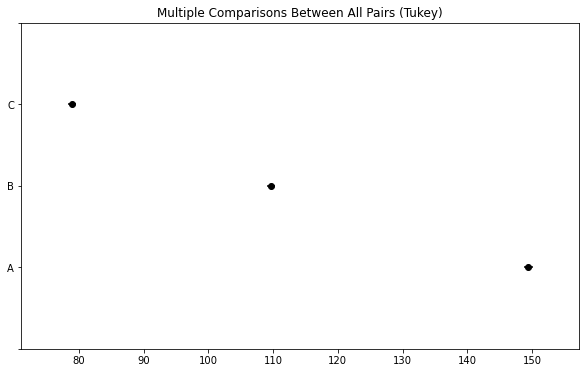

In [12]:
MultiComp = MultiComparison(ab_test_return.orders, ab_test_return.group)
print(MultiComp.tukeyhsd().summary())
print(MultiComp.tukeyhsd().plot_simultaneous())



По результатам теста видно, что различие есть среди всех групп. 
Лучше всего на пользователей влияет отсутствие оплаты за возврат товара (группа А). Похоже, что людям не нравится когда их расходы увеличиваются)

## 2. Анализ результатов, разделеные на сегменты

Проведем второе тестирование, но теперь будет две группы - контрольная и тестовая. В контрольной группе (A) клиенты будут возвращать товар бесплатно, а в тестовой (B) - оплата возврата будет стоить 50 рублей. Так же в качестве сегментов выделим пол клиента

Датасет 4 столбцами:

id – id клиента

segment – сегментация по полу (male, female)

group – 2 группы клиентов, с оплатой и без оплаты возврата товара (A, B)

orders - число заказов за месяц

In [162]:
ab_test_segment = pd.read_csv('ab_test_segment_1.csv')

In [163]:
ab_test_segment

,id,group,orders,segment
0,689,A,137,female
1,3800,A,164,female
2,1520,A,149,female
3,11580,A,181,female
4,10474,A,132,female
...,...,...,...,...
7995,8275,B,130,female
7996,6055,B,119,female
7997,8686,B,169,female
7998,4815,B,119,female


Проверим датасет на пропуски, тип данных и дубликаты

In [165]:
ab_test_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       8000 non-null   int64 
 1   group    8000 non-null   object
 2   orders   8000 non-null   int64 
 3   segment  8000 non-null   object
dtypes: int64(2), object(2)
memory usage: 250.1+ KB


In [166]:
ab_test_segment.duplicated().sum()

0

Наш датасет поделен на 2 развные части - группа А и группа В

In [168]:
ab_test_segment.group.value_counts()

A    4000
B    4000
Name: group, dtype: int64

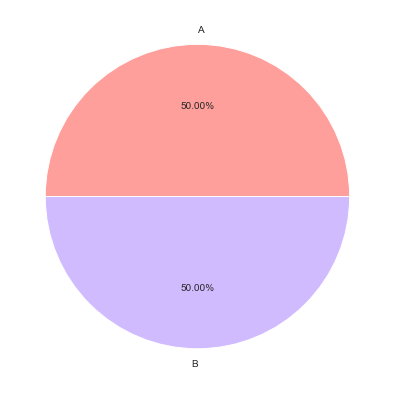

In [169]:
# Построение круглой диаграммы
plt.figure(figsize=(7, 7))
pie_group = plt.pie(ab_test_segment.groupby('group').count().reset_index().orders, labels=['A', 'B'], colors=sns.color_palette('pastel')[3:5], autopct='%0.2f%%')


Посмотрим какие доли приходятся на каждый сегмент (пол)

In [170]:
ab_test_segment.segment.value_counts()

female    5700
male      2300
Name: segment, dtype: int64

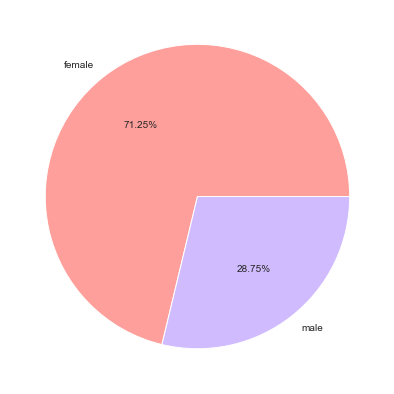

In [171]:
# plotting two groups
plt.figure(figsize=(7, 7))
pie_segment = plt.pie(ab_test_segment.groupby('segment').count().reset_index().orders, labels=['female', 'male'], autopct='%0.2f%%', colors=sns.color_palette('pastel')[3:5])


Женщин большая часть - 71.25%,  мужчин меньше - всего 28.75 %, что вполне ожидаемо, так как покупки обычно занимают больше женцин

Построим распределение для тестовой и контрольной группы

Text(0.5, 1.0, 'Test and Control Groups distributions')

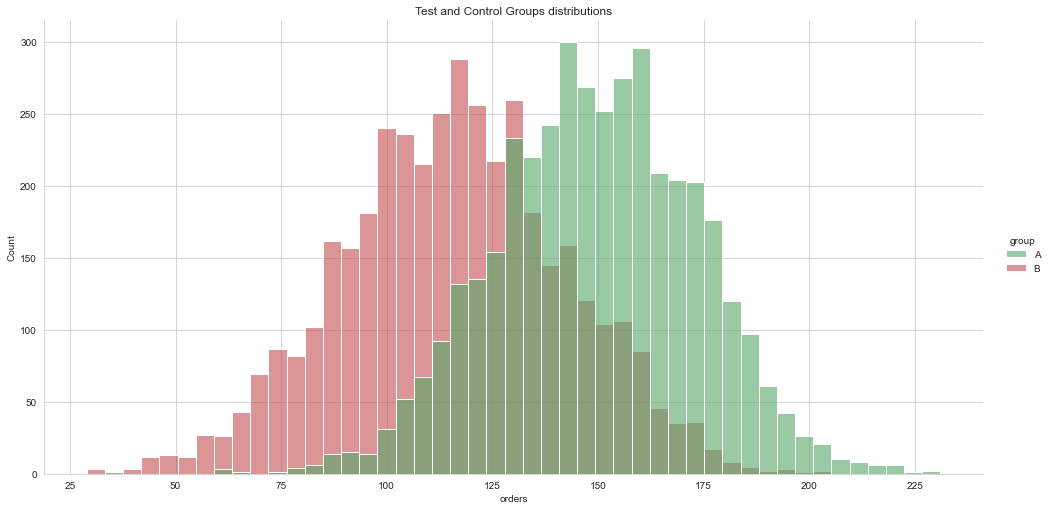

In [135]:
sns.set_style('whitegrid')
sns.displot(data=ab_test_segment, x='orders', hue='group', height=7, aspect=2, palette=sns.color_palette('deep')[2:4], alpha =0.6 )
plt.title('Test and Control Groups distributions')

Распределения выглядят нормальными, а средние у двух групп различны

Построим распределение для сегментов

Text(0.5, 1.0, 'Test and Control Groups distributions')

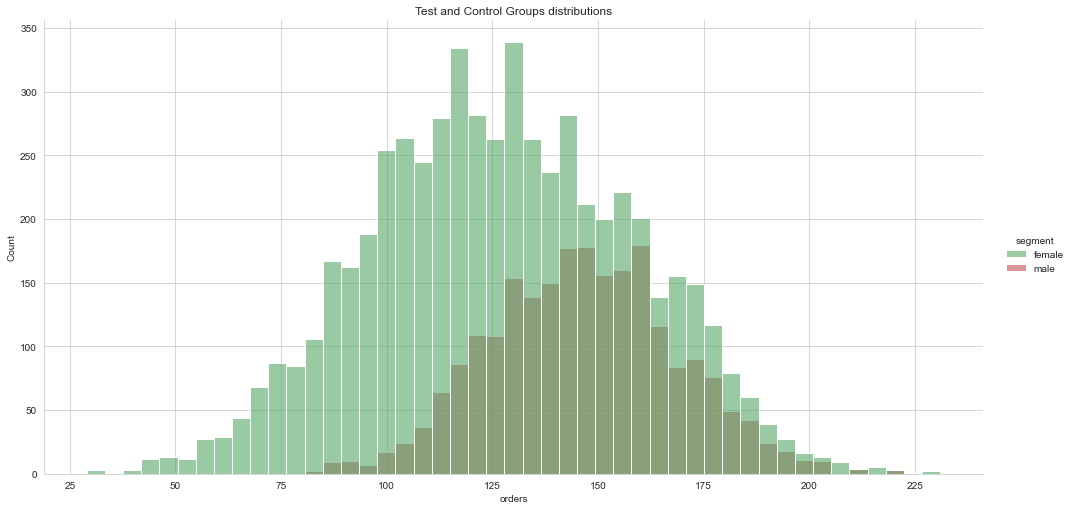

In [123]:
sns.set_style('whitegrid')
sns.displot(data=ab_test_segment, x='orders', hue='segment', height=7, aspect=2, palette=sns.color_palette('deep')[2:4], alpha =0.6 )
plt.title('Test and Control Groups distributions')

Средние различаются и по сегментам. Посчитаем средние, медиану и отклонение в сегментах

In [142]:
ab_test_segment.groupby(['group', 'segment']) \
    .agg({'orders': ['mean', 'median', 'std']})

orders                       
                     mean      median        std
group segment                                   
A     female   149.475200  150.000000  24.193014
      male     149.426000  149.000000  23.319013
B     female   109.667500  110.000000  24.511637
      male     140.841327  141.094059  19.647060

В группе А, хоть мужчин и меньше, количество заказов у них примерно такое же как и у женщин. В группе В картина меняется, у женщин среднее количество заказов падает на 30 единиц, в то время как у мужчин снижается всего до 141 заказа 

Теперь используем двухфакторный дисперсионный анализ, что бы понять как пол клиента, плата за возврат и их взаимодействие влияют на количество заказов. Так как наши данные сбалансированны, можем выбрать любой тип рассчета квадратов (typ)

In [183]:
formula = 'ab_test_segment.orders ~ ab_test_segment.segment + ab_test_segment.group + ab_test_segment.segment:ab_test_segment.group'
model = ols(formula, ab_test_segment).fit()
aov_table = anova_lm(model, typ=1)

In [184]:
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
ab_test_segment.segment,1.0,6.665719e+05,6.665719e+05,1059.308404,2.524877e-218
ab_test_segment.group,1.0,1.812165e+06,1.812165e+06,2879.871892,0.000000e+00
ab_test_segment.segment:ab_test_segment.group,1.0,4.314892e+05,4.314892e+05,685.717653,4.375892e-145
Residual,7996.0,5.031498e+06,6.292519e+02,NaN,NaN


Результаты теста говорят о том, что все факторы (пол, группа и их взаимодействие) имеют статистически значимое влияние(p-value <0.05)

Используем тест Тьюки, что бы посмотреть в каких конкретно парах взаимодействие значимо

In [185]:
ab_test_segment['comb'] = ab_test_segment['group'] + ' \ ' + ab_test_segment['segment']

In [186]:
ab_test_segment

,id,group,orders,segment,comb
0,689,A,137,female,A \ female
1,3800,A,164,female,A \ female
2,1520,A,149,female,A \ female
3,11580,A,181,female,A \ female
4,10474,A,132,female,A \ female
...,...,...,...,...,...
7995,8275,B,130,female,B \ female
7996,6055,B,119,female,B \ female
7997,8686,B,169,female,B \ female
7998,4815,B,119,female,B \ female


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj  lower    upper   reject
-------------------------------------------------------------
A \ female   A \ male  -0.0492   0.9  -2.1544    2.056  False
A \ female B \ female -39.8077 0.001 -41.5282 -38.0872   True
A \ female   B \ male  -6.1752 0.001  -8.7935  -3.5569   True
  A \ male B \ female -39.7585 0.001 -41.7755 -37.7415   True
  A \ male   B \ male   -6.126 0.001  -8.9479  -3.3041   True
B \ female   B \ male  33.6325 0.001  31.0846  36.1804   True
-------------------------------------------------------------
Figure(720x432)


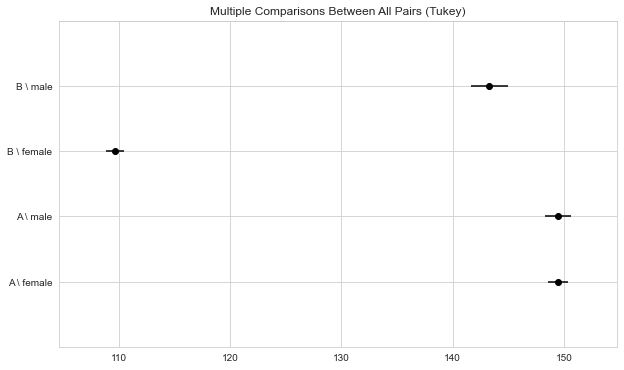

In [193]:
# Тьюки тест
MultiComp = MultiComparison(ab_test_segment.orders, ab_test_segment.comb)
print(MultiComp.tukeyhsd().summary())
print(MultiComp.tukeyhsd().plot_simultaneous())

Text(0.5, 1.0, 'Influence of factors')

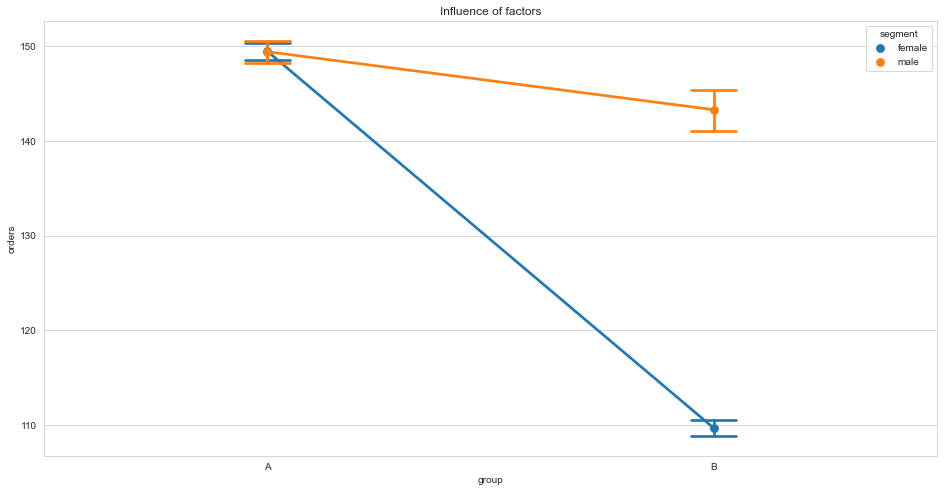

In [192]:
plt.figure(figsize=(16, 8))
sns.pointplot(x='group', y='orders', hue='segment', data=ab_test_segment, capsize=.1)
plt.title('Influence of factors')


По результатам теста можно заключить, что у мужчин и женщин в контрольной группе разницы в заказах нет. Зато когда мы вводим оплату за возврат товара 50 рублей, среднее количество покупок у женщин сразу падает, в то время как для мужчин это не слишком весомый фактор для отказа от покупки и количество заказов падает не значительно, хоть и статистически значимо. Для дальнейшего анализа можно пробовать менять размер оплаты за возврат по сегментам, или работать с результатами, которые получили.

Примечателен тот факт, что без сегментирования мы сравнивали среднестатистического покупателя в группах и не имели понятия, что мужчины более лояльны к платным возвратам. Возможно дальнеший анализ различных сегментов раскроет еще больше полезных инсайтов, с помощью которых можно повысить доходность маркетплейса и уменьшить отток клиентов